In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
tf.__version__

'2.1.0'

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
SEED = 42
np.random.seed(SEED)

TARGET = "AI"
DATASET = "dataset.pickle"

In [6]:
df = pd.read_pickle(DATASET)
df

,crunchbase_ID,home_text,aboutus_text,overview_text,whatwedo_text,company_text,whoweare_text,AI
0,1916,Skip to main content Products GPU accelerated ...,NaN,NaN,NaN,NaN,NaN,1
1,1917,Our AIs Research Company Careers Get in Touch ...,NaN,NaN,NaN,Our AIs Research Company Careers Get in Touch ...,NaN,1
2,1918,Toggle navigation Product Projects Company His...,NaN,NaN,NaN,NaN,NaN,1
3,1919,Brainpeek Solutions Create a seamless online u...,Brainpeek Solutions Create a seamless online u...,NaN,NaN,NaN,NaN,1
4,1920,The Tool Our Languages Services Extract Produc...,The Tool Our Languages Services Extract Produc...,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...
4889,2735,Username or Email L senord Remember me Norsk S...,Username or Email L senord Remember me Norsk S...,NaN,NaN,NaN,NaN,0
4890,5944,Solutions Solution for distributors Covered re...,NaN,NaN,NaN,NaN,NaN,0
4891,5251,BROWSE PRODUCTS Variety Cases Pasta Mac and Ch...,NaN,NaN,NaN,NaN,NaN,0
4892,4225,Pricing Documentation Community Changelog Logi...,NaN,NaN,NaN,NaN,NaN,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894 entries, 0 to 4893
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   crunchbase_ID  4894 non-null   object
 1   home_text      4894 non-null   object
 2   aboutus_text   2212 non-null   object
 3   overview_text  66 non-null     object
 4   whatwedo_text  50 non-null     object
 5   company_text   477 non-null    object
 6   whoweare_text  83 non-null     object
 7   AI             4894 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 306.0+ KB


In [8]:
df.isnull().mean()

crunchbase_ID    0.000000
home_text        0.000000
aboutus_text     0.548018
overview_text    0.986514
whatwedo_text    0.989783
company_text     0.902534
whoweare_text    0.983040
AI               0.000000
dtype: float64

In [9]:
def remove_non_alphabets(X):
    regs = []
    for sent in X:
        x = re.sub('[^A-Za-z]'," ",str(sent))
        regs.append(x)
    return regs


def create_corpus(X):
    """Decompose text to corpus (e.g. `This is a pen` to [ `This`, `is`, `a`, `pen` ])
    
    Arguments:
        texts: list(str) / Text list.
        
    Returns:
        list(str) / Corpus list.
    """
    
    corpus = []
    for sent in X:
        words = [ word.lower() for word in word_tokenize(sent) ]
        corpus.append(words)
        
    return corpus


def remove_stopwords(X):
    stop_words = set(stopwords.words('english'))
    filterd_words = []
    keep = ["n't", "not", "no"]
    for words in X:
        x = [word for word in words if word not in stop_words or word in keep] 
        filterd_words.append(x)
    return filterd_words


def lemmatize(X):
    """taking the root of every word"""
    lemmatized = []
    for words in X:
        x = [WordNetLemmatizer().lemmatize(word) for word in words]
        lemmatized.append(x)
    return lemmatized


def remove_unnecessary_words(X):
    """taking words that are bigger than 2"""
    filterd = []
    for words in X:
        x = [word for word in words if len(word) >= 2]
        filterd.append(x)
    return filterd    

def tokenize_and_pad(X, tokenizer=None, padded=True):
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>')
        tokenizer.fit_on_texts(X)
        seq = tokenizer.texts_to_sequences(X)
        tmp = seq
        seq_padded = pad_sequences(seq, maxlen=input_length, padding='post', truncating='post')
        return tokenizer, seq_padded
    seq = tokenizer.texts_to_sequences(X)
    seq_padded = pad_sequences(seq, maxlen=input_length, padding='post', truncating='post')
    return seq_padded

In [10]:
df_home_text = df[['home_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_aboutus_text = df[df['aboutus_text'].notnull()][['aboutus_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_overview_text = df[df['overview_text'].notnull()][['overview_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_whatwedo_text = df[df['whatwedo_text'].notnull()][['whatwedo_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_company_text = df[df['company_text'].notnull()][['company_text', 'AI']].set_axis( ['text', 'AI'], axis=1)
df_whoweare_text = df[df['whoweare_text'].notnull()][['whoweare_text', 'AI']].set_axis( ['text', 'AI'], axis=1)

In [11]:
df = pd.concat([df_home_text, df_aboutus_text, df_overview_text, df_whatwedo_text, df_company_text, df_whoweare_text], axis=0, ignore_index=True)
df = df.sample(frac=1)

In [12]:
X = df['text'].values.astype(str)
y = df[TARGET].values

In [13]:
%%time

X = remove_non_alphabets(X)
X = create_corpus(X)
X = remove_stopwords(X)
X = lemmatize(X)
# X = remove_unnecessary_words(X)

Wall time: 43.3 s


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

In [15]:
input_length = 100
tokenizer, X_train_processed  = tokenize_and_pad(X_train)
X_test_processed = tokenize_and_pad(X_test, tokenizer)

input_dim = len(tokenizer.word_index)+1
output_dim = 100

In [16]:
# embedding_dict = {}
# word_index = tokenizer.word_index
# with open('glove.6B.100d.txt','r', encoding="utf8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vectors = np.asarray(values[1:], 'float32')
#         embedding_dict[word] = vectors

# max_words = input_dim
# embedding_dims = output_dim

# embedding_matrix = np.zeros((max_words, embedding_dims))
# for word, i in word_index.items():
#     if i > max_words:
#         continue
        
#     emb_vec = embedding_dict.get(word)    
#     if emb_vec is not None:
#         embedding_matrix[i] = emb_vec  

In [17]:
#, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)

In [52]:
def make_model(input_dim, output_dim, input_length, lr=1e-5):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(input_dim, output_dim, input_length=input_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, activation='tanh', return_sequences=False, kernel_regularizer=regularizers.l2(0.01))),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model


def train_model(model, callbacks, verbose=0):
    history = model.fit(X_train_processed, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=verbose)
    return history

In [53]:
def repeat_training(callbacks, times=30):
    """Repeat trainig to get an estimate results"""
    scores = pd.DataFrame(columns=['N', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])
    for i in range(1, times+1):
        model = make_model(input_dim, output_dim, input_length)

        model.compile(loss="binary_crossentropy",
                           optimizer="adam",
                           metrics=["accuracy"])
    
        history = train_model(model, callbacks, 0)
        
        train_loss, train_acc = model.evaluate(X_train_processed, y_train, verbose=0)
        test_loss, test_acc = model.evaluate(X_test_processed, y_test, verbose=0)
        
        scores.loc[i, 'N'] = i
        scores.loc[i, 'train_loss'] = train_loss
        scores.loc[i, 'train_acc'] = train_acc
        scores.loc[i, 'test_loss'] = test_loss
        scores.loc[i, 'test_acc'] = test_acc
        
    scores['train_loss'] = scores['train_loss'].astype(float)
    scores['train_acc'] = scores['train_acc'].astype(float)
    scores['test_loss'] = scores['test_loss'].astype(float)
    scores['test_acc'] = scores['test_acc'].astype(float)
    
    print(f"Train Acc: {scores['train_acc'].mean():.23f} \nTest Acc: {scores['test_acc'].mean():.3f}")
    return scores

In [54]:
model = make_model(input_dim, output_dim, input_length, lr=1e-4)
# model = make_model(input_dim=10000, output_dim=50, input_length=50, lr=1e-4)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9372500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 8)                 3360      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 9,375,869
Trainable params: 9,375,869
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.evaluate(X_test_processed, y_test)

779/779 [==============================] - 1s 955us/sample - loss: 1.2420 - accuracy: 0.4929


[1.2420058320820409, 0.49293968]

In [56]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('lstm_model.h5', monitor='val_accuracy', save_best_only=True)
early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-5, verbose=1)
EPOCHS = 40
BATCH_SIZE = 64
callbacks = [early_stoping, checkpoint]

# summary = repeat_training(callbacks, 10)
history = train_model(model, callbacks, 1)

Train on 6302 samples, validate on 701 samples
Epoch 1/40
6302/6302 [==============================] - 11s 2ms/sample - loss: 1.2073 - accuracy: 0.5238 - val_loss: 1.1721 - val_accuracy: 0.5906
Epoch 2/40
6302/6302 [==============================] - 8s 1ms/sample - loss: 1.1410 - accuracy: 0.6073 - val_loss: 1.1106 - val_accuracy: 0.6220
Epoch 3/40
6302/6302 [==============================] - 8s 1ms/sample - loss: 1.0822 - accuracy: 0.6541 - val_loss: 1.0561 - val_accuracy: 0.6662
Epoch 4/40
6302/6302 [==============================] - 8s 1ms/sample - loss: 1.0293 - accuracy: 0.7015 - val_loss: 1.0072 - val_accuracy: 0.6847
Epoch 5/40
6302/6302 [==============================] - 9s 1ms/sample - loss: 0.9820 - accuracy: 0.7183 - val_loss: 0.9633 - val_accuracy: 0.6947
Epoch 6/40
6302/6302 [==============================] - 8s 1ms/sample - loss: 0.9387 - accuracy: 0.7404 - val_loss: 0.9229 - val_accuracy: 0.7104
Epoch 7/40
6302/6302 [==============================] - 8s 1ms/sample - loss

In [57]:
model.evaluate(X_test_processed, y_test)

779/779 [==============================] - 0s 200us/sample - loss: 0.5173 - accuracy: 0.8241


[0.5172708318383458, 0.8241335]

In [58]:
# summary.describe()

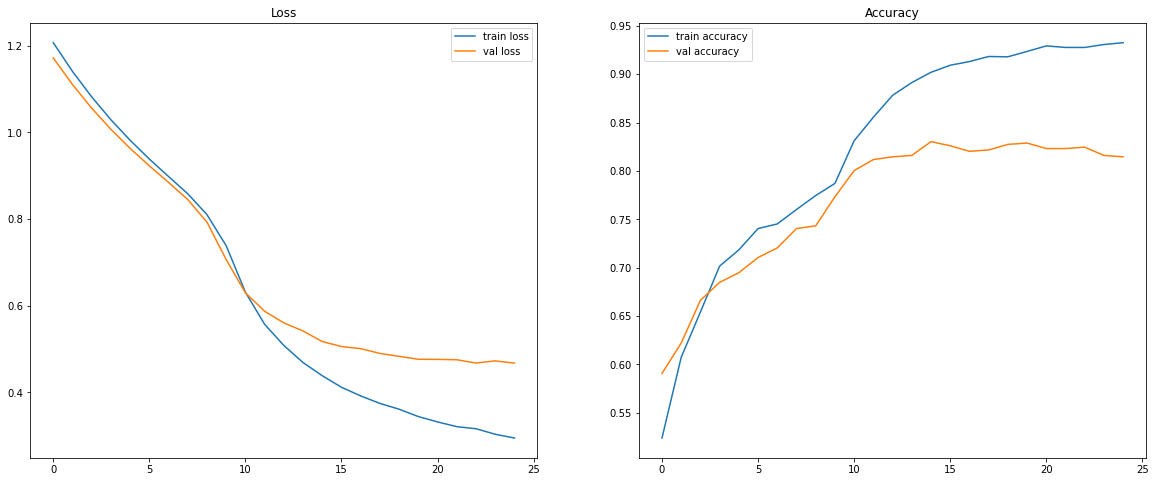

In [59]:
train_loss = history.history['loss']         # train loss
train_acc = history.history['accuracy']      # train accuracy
val_loss = history.history['val_loss']       # validation loss
val_acc = history.history['val_accuracy']    # validation accuracy

# Plotting 
plt.figure(figsize=(20, 8))   # figure size

plt.subplot(1, 2, 1)          # first plot: loss plot
# line plot
plt.plot( train_loss, label='train loss')   # train loss line plot
plt.plot( val_loss, label='val loss')       # validation loss line plot

plt.title('Loss')     # plot title
plt.legend()          # to display labels

plt.subplot(1, 2, 2)         # second plot: accuracy plot
# line plot
plt.plot(train_acc, label='train accuracy')    # train accuracy line plot
plt.plot(val_acc, label='val accuracy')        # validation accuracy line plot

plt.title('Accuracy')    # plot title
plt.legend()             # to display labels
plt.show();

In [ ]:
# summary.describe()

In [ ]:
# model.evaluate(X_test_processed, y_test)
preds = model.predict(X_test_processed).round().astype(int)

In [ ]:
conf = confusion_matrix(y_test, preds)
sns.heatmap(conf, annot=True);
plt.xlabel('Predicted')
plt.ylabel('Actual');